In [2]:
import pandas as pd
from ensemble_boxes import *
import numpy as np
from pycocotools.coco import COCO

In [3]:
submission_files = [
    "/opt/ml/baseline/mmdetection/work_dirs/230516_1147_YOLOV3_epochs20_cosineannealing/submission.csv",
    "/opt/ml/ultralytics-main/submission/submission_yolov8_100_x.csv"
    ]
submission_df = [pd.read_csv(file) for file in submission_files]

In [4]:
submission_df

[                                       PredictionString       image_id
 0     0 0.14444637 247.14667 682.8329 299.55457 750....  test/0000.jpg
 1     0 0.1576544 126.70186 3.831421 523.1841 274.25...  test/0001.jpg
 2     0 0.16309625 875.8771 465.93277 1009.2189 651....  test/0002.jpg
 3     0 0.2234018 4.7114906 422.62482 109.80182 897....  test/0003.jpg
 4     0 0.41986096 436.58887 412.81055 648.6028 577....  test/0004.jpg
 ...                                                 ...            ...
 4866  0 0.5115436 297.14862 339.5538 674.0139 679.38...  test/4866.jpg
 4867  3 0.6915468 406.69864 321.5642 782.5477 713.49...  test/4867.jpg
 4868  0 0.11236079 27.913422 3.7829895 965.8954 944....  test/4868.jpg
 4869  0 0.4545776 -20.194061 307.9862 1037.1809 988....  test/4869.jpg
 4870  0 0.013564635 239.51947 823.05896 298.2904 853...  test/4870.jpg
 
 [4871 rows x 2 columns],
                                        PredictionString       image_id
 0     7 0.9772128462791443 603.4990

In [5]:
annotation = '../dataset/test.json'
coco = COCO(annotation)
image_ids = submission_df[0]['image_id'].tolist()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [21]:
prediction_strings = []
file_names = []
iou_thr = 1 #0.6
weights = [1.0, 1.5]

for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        
        if len(predict_list)==0 or len(predict_list)==1:
            continue
            
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        
        for box in predict_list[:, 2:6].tolist():
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
            
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))
    
    if len(boxes_list):
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(int(label)) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    file_names.append(image_id)

/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:63: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:51: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:42: UserWarning: X1 < 0 in box. Set it to 0.
  warnings.warn('X1 < 0 in box. Set it to 0.')
/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:54: UserWarning: Y1 < 0 in box. Set it to 0.
  warnings.warn('Y1 < 0 in box. Set it to 0.')


In [22]:
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv('./Ensemble/submission_ensemble.csv')

submission.head()

,PredictionString,image_id
0,7 0.5863277077674866 603.4990234375 517.536315...,test/0000.jpg
1,5 0.5698837995529175 343.6825256347656 250.462...,test/0001.jpg
2,1 0.536336624622345 777.1837768554688 403.4861...,test/0002.jpg
3,9 0.5748503565788269 143.69482421875 264.74258...,test/0003.jpg
4,0 0.44954509735107423 190.72122192382812 251.4...,test/0004.jpg


In [23]:
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

['0', '0.05717251', '158.34863', '155.50702', '246.90988', '281.1536', '0', '0.054594703', '0.71144485', '258.49966', '116.86623', '332.15018', '0', '0.0065767444', '3.8956108', '884.3562', '31.74506', '912.7416', '0', '0.001530248', '-1.9725952', '119.607635', '821.72876', '760.82117', '0', '0.001189071', '24.47464', '240.01532', '416.2441', '597.41595', '0', '0.001150223', '-3.978241', '429.5126', '846.2533', '998.7444', '0', '0.00048201636', '42.85573', '517.72705', '387.53967', '843.1085', '1', '0.030455379', '0.71144485', '258.49966', '116.86623', '332.15018', '1', '0.003128032', '3.8956108', '884.3562', '31.74506', '912.7416', '1', '0.0015250623', '-3.978241', '429.5126', '846.2533', '998.7444', '1', '0.0007457327', '17.101791', '256.3196', '325.45258', '584.7373', '1', '0.00042431388', '42.85573', '517.72705', '387.53967', '843.1085', '2', '0.00055087724', '3.8956108', '884.3562', '31.74506', '912.7416', '3', '0.0005922429', '3.8956108', '884.3562', '31.74506', '912.7416', '5', 

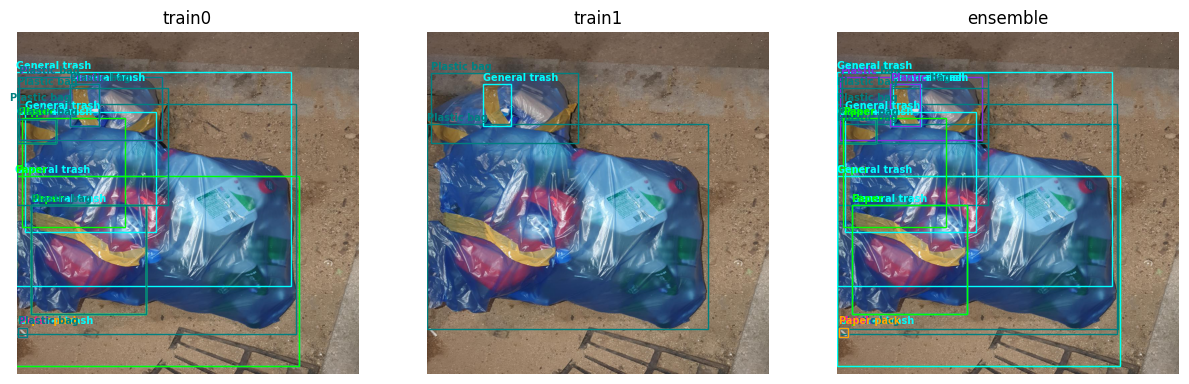

In [24]:
colors = ['cyan', 'lime', 'orange', 'deeppink', 'gold', 'blueviolet', 'red', 'teal', 'hotpink', 'mediumspringgreen']
category = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

fig, axes = plt.subplots(1, 3, figsize=(15, 7))

image_id = image_ids[14]
img_path = os.path.join("../dataset/", image_id)
                        
informations = {f"train{idx}" : df for idx, df in enumerate(submission_df)}
informations['ensemble'] = submission
for i, (name, df) in enumerate(informations.items()):
    predict_list = str(df[df['image_id'] == image_id]['PredictionString'].tolist()[0]).split()
    x = i % 3
    # y = i // 3
    img = Image.open(img_path)
    print(predict_list)

    axes[x].imshow(img)
    axes[x].axis('off')
    axes[x].set_title(name)

    for idx in range(len(predict_list)//6):
        label, confidence, x_min, y_min, x_max, y_max = int(predict_list[6*idx + 0]), float(predict_list[6*idx + 1]), float(predict_list[6*idx + 2]), float(predict_list[6*idx + 3]), float(predict_list[6*idx + 4]), float(predict_list[6*idx + 5])
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=colors[label], facecolor='none')
        axes[x].add_patch(rect)
        axes[x].text(x_min, y_min-10, f"{category[label]}", color=colors[label], fontsize=7, weight='bold')
fig.set_tight_layout
plt.show()